<a href="https://colab.research.google.com/github/Rakesh2395/Body-pose-detection-in-PyTorch/blob/main/Human_Body_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries**

In [3]:
#Import libraries
import os
import numpy as np

#For importing keypoint RCNN pretrained model and image preprocessing
import torchvision
import torch

#For reading the image
import cv2

#For visualization
import matplotlib.pyplot as plt


In [1]:
#Mount google drive
#Change directory to the respective folder containing images folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Bodypose'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Bodypose


## **Human Keypoints to identify**

In [6]:
# List of keypoints for humans (count=17)
human_keypoints = ['nose','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
                'right_elbow','left_wrist','right_wrist','left_hip','right_hip','left_knee', 'right_knee', 'left_ankle','right_ankle']


print(human_keypoints)

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


## **Function to identify possibles connections**

In [7]:
# Possible connections between the human key points to form a structure
def possible_keypoint_connections(keypoints):
    connections = [       
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
    return connections


connections = possible_keypoint_connections(human_keypoints)


## **Functions to plot Keypoints and skeleton of input image**

In [8]:
def plot_keypoints(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
      # check the confidence score of the detected person
      if confs[person_id]>conf_threshold:
        # grab the keypoint-locations for the detected person
        keypoints = all_keypoints[person_id, ...]
        # grab the keypoint-scores for the keypoints
        scores = all_scores[person_id, ...]
        # iterate for every keypoint-score
        for kp in range(len(scores)):
            # check the confidence score of detected keypoint
            if scores[kp]>keypoint_threshold:
                # convert the keypoint float-array to a python-list of intergers
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # pick the color at the specific color-id
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # draw a cirle over the keypoint location
                cv2.circle(img_copy, keypoint, 30, color, -1)

    return img_copy



In [9]:
def plot_skeleton(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(output["keypoints"])>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # iterate for every limb 
            for conn_id in range(len(connections)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[connections[conn_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[connections[conn_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, connections[conn_id][0]], all_scores[person_id, connections[conn_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 25)

    return img_copy

## **Loading pretrained model**

In [10]:
# create a model from the pretrained keypointrcnn_resnet50_fpn class
pretrained_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

# call the eval() method to prepare the model for inference mode.
pretrained_model.eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


  0%|          | 0.00/226M [00:00<?, ?B/s]

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

## **Image Preprocessing, Modeling, Postprocessing**

In [27]:
# import the transforms module
from torchvision import transforms as T

# Read the image using opencv 
img_path = "images/image1.JPG"
img = cv2.imread(img_path)


# preprocess the input image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

# forward-pass the model
output = pretrained_model([img_tensor])[0]

print(output.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


## **Plot Keypoints and skeleton of input image**

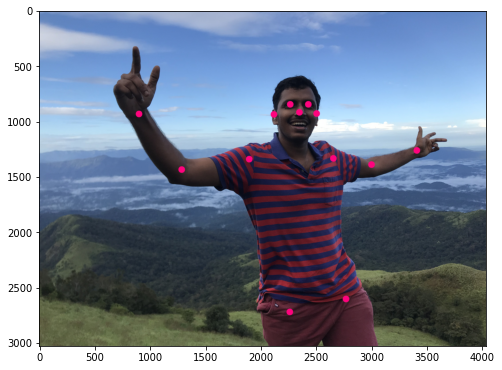

In [28]:
keypoints_img = plot_keypoints(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

cv2.imwrite("output/keypoints-img.jpg", keypoints_img)

plt.figure(figsize=(8, 8))
plt.imshow(keypoints_img[:, :, ::-1])
plt.show()

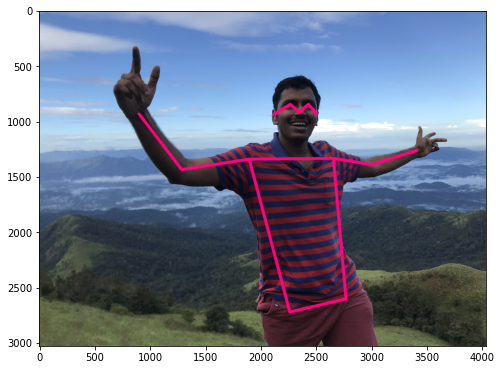

In [29]:
skeleton_img = plot_skeleton(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

cv2.imwrite("output/skeleton-img.jpg", skeleton_img)

plt.figure(figsize=(8, 8))
plt.imshow(skeleton_img[:, :, ::-1])
plt.show()